# Issues with CAFE-f6

While spinning up this project, I discovered a number of issues with the CAFE-f6 forecasts that must be contended with when assessing the hindcasts.

These issues are breifly described/demonstrated in this notebook.

In [20]:
import xarray as xr

import matplotlib.pyplot as plt

In [21]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

## 1. Application of forcing

Some of the forcing fields in the CAFE-f6 forecasts are applied in a way that is different that the CMIP DCPP recomendations. Principally, a number of the forcing fields switch from time-varying to fixed based on the *initialisation date* of the forecasts. **This means that the same calendar year can experience different forcing, depending on its lead time.** For example (see below), The lead 2 year forecast of 2002 (initialised 2000) will be forced with 2002 volcanic forcing, but the lead 1 forecast of 2002 (initialised 2001) will be forced with 2008 forcing. This could make the forecasts difficult to interpret and baseline.

The relevant lines that specify the forcing in the CAFE-f6 model namelist (see https://github.com/csiro-dcfp/cm-forecasts/blob/fb22ae161bfce6803435c0d10fa74a9d49e4bffc/ref/MODEL/input.in) are:

```
 &aerosol_nml
    use_aerosol_timeseries = .false.
    aerosol_dataset_entry =  INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
    family_names = "small_dust", "large_dust", "sulfate", "aerosol"
    in_family1 = F,F,F,F,T,T,T,T,T,F,F,F,
    in_family2 = F,F,F,F,F,F,F,F,F,T,T,T,
    in_family3 = T,F,F,F,F,F,F,F,F,F,F,F,
    in_family4 = T,T,T,T,T,T,T,T,T,T,T,T,
    data_names = "so4", "organic_carbon", "black_carbon", "sea_salt",
                 "dust_0.1", "dust_0.2", "dust_0.4", "dust_0.8",
                 "dust_1.0", "dust_2.0", "dust_4.0", "dust_8.0",
    filename = "aerosol.climatology.nc"
/
 &aerosolrad_package_nml
    volcanic_dataset_entry = 1, 1, 1, 0, 0, 0,
    REPEAT_VOLCANO_YEAR
    VOLCANO_YEAR_USED
    using_volcanic_lw_files = .false.,
    lw_ext_filename = "             "
    lw_ext_root = "     "
    lw_asy_filename = "             "
    lw_asy_root = "     "
    lw_ssa_filename = "             "
    lw_ssa_root = "     "
    using_volcanic_sw_files = .true.,
    sw_ext_filename = "extsw_data.nc"
    sw_ext_root = "extsw"
    sw_ssa_filename = "omgsw_data.nc"
    sw_ssa_root = "omgsw"
    sw_asy_filename = "asmsw_data.nc"
    sw_asy_root = "asmsw"
    do_lwaerosol = .true.,
    do_swaerosol = .true.,
    aerosol_data_set = 'shettle_fenn',
    optical_filename = "aerosol.optical.dat",
    aerosol_optical_names = "sulfate_30%", "sulfate_35%", "sulfate_40%", "sulfate_45%",
                            "sulfate_50%", "sulfate_55%", "sulfate_60%", "sulfate_65%",
                            "sulfate_70%", "sulfate_75%", "sulfate_80%", "sulfate_82%",
                            "sulfate_84%", "sulfate_86%", "sulfate_88%", "sulfate_90%",
                            "sulfate_91%", "sulfate_92%", "sulfate_93%", "sulfate_94%",
                            "sulfate_95%", "sulfate_96%", "sulfate_97%", "sulfate_98%",
                            "sulfate_99%", "sulfate_100%","organic_carbon","soot",
                            "sea_salt",    "dust_0.1",    "dust_0.2",    "dust_0.4",
                            "dust_0.8",    "dust_1.0",    "dust_2.0",    "dust_4.0",
                            "dust_8.0"
.
.
.
&ozone_nml
    BASIC_OZONE_TYPE
    OZONE_DATASET_ENTRY
    data_name = "ozone",
    FILENAME
.
.
.
 &radiation_driver_nml
       rad_time_step= 10800,
       time_varying_solar_constant = .false.,
       solar_dataset_entry = 1990,1,1,0,0,0,
       rad_package = 'sea_esf',
       do_clear_sky_pass=.true.,
       calc_hemi_integrals = .false.,
       renormalize_sw_fluxes=.true.,
       all_step_diagnostics = .true.,
       zenith_spec = 'diurnally_varying'
       using_restart_file = .false.
/
 &radiative_gases_nml
       verbose = 3
       gas_printout_freq = 240
       time_varying_co2 = .true.,
       co2_variation_type = 'linear',
       co2_specification_type = 'time_series',
       co2_floor = 100.0E-06,
       co2_ceiling = 1600.0E-06,
       co2_data_source = 'input'
       time_varying_ch4 = .true.,
       ch4_variation_type = 'linear'
       ch4_specification_type = 'time_series'
       ch4_data_source = 'input'
       time_varying_n2o = .true.,
       n2o_variation_type = 'linear'
       n2o_specification_type = 'time_series'
       n2o_data_source = 'input'
       time_varying_f11 = .true.,
       f11_variation_type = 'linear'
       f11_specification_type = 'time_series'
       f11_data_source = 'input'
       time_varying_f12 = .true.,
       f12_variation_type = 'linear'
       f12_specification_type = 'time_series'
       f12_data_source = 'input'
       time_varying_f113 = .true.,
       f113_variation_type = 'linear'
       f113_specification_type = 'time_series'
       f113_data_source = 'input'
       time_varying_f22 = .true.,
       f22_variation_type = 'linear'
       f22_specification_type = 'time_series'
       f22_data_source = 'input'
```

where the following replacements are made before submission (see https://github.com/csiro-dcfp/cm-forecasts/blob/fb22ae161bfce6803435c0d10fa74a9d49e4bffc/src/run_CAFE_forecasts.sh.in):

**a.** Replace
 
  ```
  INPUT_AEROSOL_TIME -> "AYEAR, 1, 1, 0, 0, 0"
  ```
   
  where AYEAR is the middle year of the decade in which the forecast is initialised (e.g. AYEAR=2005 for any start date in the 2000s). If AYEAR is greater than 2015, then 2015 is used.
   
**b.** If the forecast is initialised after 2000 then replace,
 
  ```
  REPEAT_VOLCANO_YEAR -> "repeat_volcano_year=.true."
  VOLCANO_YEAR_USED -> "volcano_year_used = 2008,"
  ```
   
  otherwise these lines are commented out.
   
**c.** If the forecast is initialised after 2004 then replace,

  ```
  BASIC_OZONE_TYPE -> "fixed_year"
  OZONE_DATASET_ENTRY -> "ozone_dataset_entry=2014, 1, 1, 0, 0, 0,"
  FILENAME -> "cm3_2014_o3.padded.nc"
  ```
   
  otherwise replace,
   
  ```
  BASIC_OZONE_TYPE -> "time_varying"
  FILENAME -> "CM3_CMIP6_1950-2014_O3.nc"
  ```
   
  and `OZONE_DATASET_ENTRY` is commented out.
   
In addition, the following is added to the field table (see https://github.com/csiro-dcfp/cm-forecasts/blob/fb22ae161bfce6803435c0d10fa74a9d49e4bffc/ref/MODEL/field_table_bgc):

**d.** If the forecast is initialised after 2007 then,

  ```
  aco2_file = "INPUT/co2_obs.padded.nc"
  ```
   
  otherwise,
   
  ```
  aco2_file = "INPUT/co2_obs.nc"
  ```

I've been told these files are used by the bgc component of the model. Notably, `co2_obs.padded.nc` includes projected values into the future, but both files are identical (see below) in their overlapping period so the switch from `co2_obs.nc` to `co2_obs.padded.nc` seems to be redundant.

Forcing files are copied from `"/g/data/v14/vxk563/CAFE/CM21_c5/INIT/STATIC/"` when a forecast is run (see https://github.com/csiro-dcfp/cm-forecasts/blob/fb22ae161bfce6803435c0d10fa74a9d49e4bffc/settings.sh#L29 and https://github.com/csiro-dcfp/cm-forecasts/blob/fb22ae161bfce6803435c0d10fa74a9d49e4bffc/src/run_CAFE_forecasts.sh.in#L90)

### So what does this mean?

#### Aerosols climatologies

Aerosol forcing climatologies are provided per decade. Forecasts initialised prior to 2020 are forced using the climatologies corresponding to the decade of their initialialisation (e.g. 2000s forcing climatologies for every forecast initialised in 2000-2009). Forecasts initialised in 2020 of later use the 2010s aerosol forcing climatologies.

**However**, the aerosol climatologies provided are actually identical to the 2000s climatology for all decades after the 2000s:

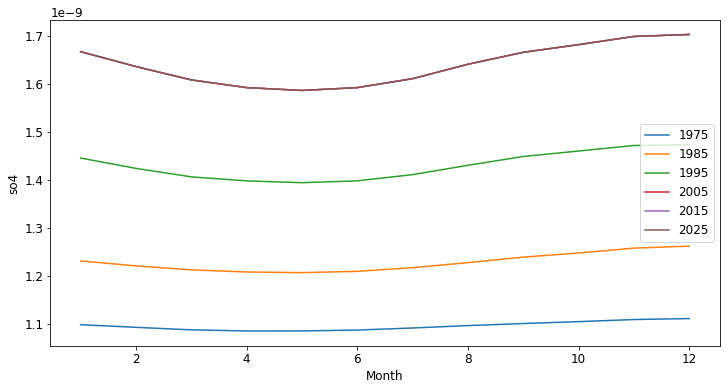

In [22]:
INIT_dir = "/g/data/v14/vxk563/CAFE/CM21_c5/INIT/STATIC/"

ds = xr.open_dataset(f'{INIT_dir}/aerosol.climatology.nc')

periods = range(1975, 2030, 10)
for p in periods:
    so4 = ds['so4'].isel(sigma_full=0).sel(time=str(p)).mean(['lat','lon'])
    plt.plot(range(1,13), so4)  
    
plt.xlabel("Month")
plt.ylabel("so4")
_ = plt.legend(periods)

Therefore

> <span style="color:red">If initialised during or before 1999, we use the aerosol forcing climatologies corresponding to the decade of initialisation \
If initialised after 1999, we use the aerosol forcing climatologies for the 2000s </span>

#### Volcanic forcing
Time varying (monthly) volcanic forcing is used for forecasts initialised prior to or during 2000, and 2008 volcanic forcing is used for those initialised after 2000.

**However**, the time-varying volcanic forcing provided is actually identical to 1999-12 for all values after 1999-12:

In [28]:
ds = xr.open_dataset(f'{INIT_dir}/extsw_data.nc')
matched = all((ds.sel(time='1999-12').squeeze() == ds.sel(time=slice('2000',None))).all())
print(f"All extsw_data.nc are constant after 1999-12: {matched}")

ds = xr.open_dataset(f'{INIT_dir}/omgsw_data.nc')
matched = all((ds.sel(time='1999-12').squeeze() == ds.sel(time=slice('2000',None))).all())
print(f"All omgsw_data.nc are constant after 1999-12: {matched}")

ds = xr.open_dataset(f'{INIT_dir}/asmsw_data.nc')
matched = all((ds.sel(time='1999-12').squeeze() == ds.sel(time=slice('2000',None))).all())
print(f"All asmsw_data.nc are constant after 1999-12: {matched}")

All extsw_data.nc are constant after 1999-12: True
All omgsw_data.nc are constant after 1999-12: True
All asmsw_data.nc are constant after 1999-12: True


Therefore

> <span style="color:red"> We use time varying volcanic forcing up until 1999-12, and then 1999-12 levels from 2000-01 onwards. (Because the forcing files don't actually change after 1999-12, the switch to 2008 forcing in our forecast scripts for initialisation dates after 2000 actually does nothing, other than to allow forecasts to be run beyond the maximum time of the forcing files, 2010-12).<span>

#### Ozone forcing
Time varying (monthly) ozone forcing is used for forecasts initialised prior to or during 2004, and 2014 ozone forcing is used for those initialised after 2004.

Therefore

> <span style="color:red">If initialised during or before 2004, we use time varying monthly (CMIP6) ozone forcing \
If initialised after 2004, we use the 2014 ozone forcing <span>

#### Solar forcing
The namelist (see above) suggests that fixed 1990 solar forcing is applied for all forecasts.

#### Radiative gas forcing
These are taken from the `*_gblannualdata` files and are time varying regardless of forecast initialisation date.

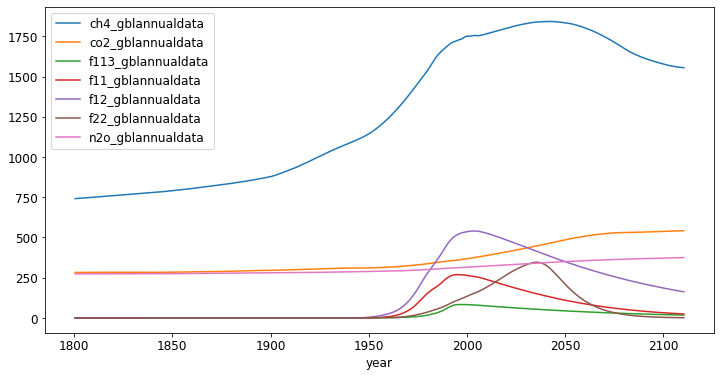

In [36]:
def read_gblannualdata(file_name):
    with open(file_name, 'r') as data:
        next(data)
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return xr.DataArray(y, dims=('year'), coords={'year': x})

files = ['ch4_gblannualdata', 'co2_gblannualdata', 'f113_gblannualdata', 'f11_gblannualdata', 
         'f12_gblannualdata', 'f22_gblannualdata', 'n2o_gblannualdata']
for file in files:
    ds = read_gblannualdata(f'{INIT_dir}/{file}')
    ds.plot()
plt.legend(files)

Additional, `co2_obs.nc` to `co2_obs.padded.nc` are are provided to the bgc component of the model (see above). Their values are identical in the overlap period, but the future scenario appears to be different than that used for `co2_gblannualdata`:

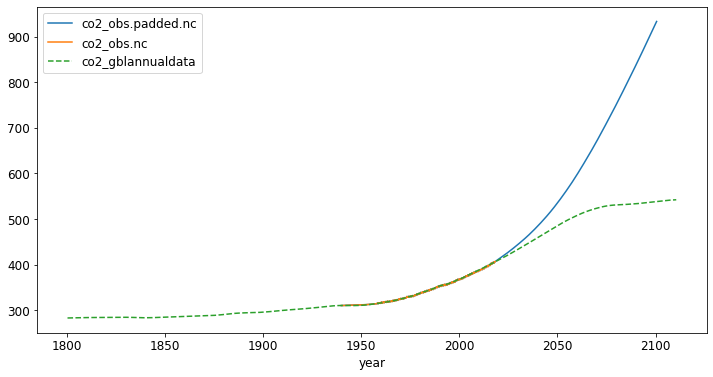

In [46]:
ds1 = xr.open_dataset(f'{INIT_dir}/co2_obs.nc', decode_times=False)
ds2 = xr.open_dataset(f'{INIT_dir}/co2_obs.padded.nc', decode_times=False)

ds1_gbl = ds1['co2'].mean(['grid_x_T','grid_y_T'])
ds2_gbl = ds2['co2'].mean(['grid_x_T','grid_y_T'])

plt.plot(ds2_gbl.time+1700, ds2_gbl, label='co2_obs.padded.nc')
plt.plot(ds1_gbl.time+1700, ds1_gbl, label='co2_obs.nc')
ds = read_gblannualdata(f'{INIT_dir}/co2_gblannualdata')
ds.plot(label='co2_gblannualdata', linestyle="--")

plt.legend()

Therefore

> <span style="color:red">We use time varying observed and projected radiative gas forcing out to 2110. However, it's not clear to me what scenario is used, or when the switch is made from observations to projections. The scenario used is different for `co2_gblannualdata` and `co2_obs.padded.nc`: it looks like `co2_gblannualdata` uses RCP4.5 and `co2_obs.padded.nc` uses RCP 8.5.</span>

### How are we inconsistent with CMIP6 DCPP?
The CMIP6 docs (https://doi.org/10.5194/gmd-9-1937-2016) request historical forcings are based as far as possible on observations and cover the period 1850–2014:

>The historical forcings are based as far as possible on observations and cover the period 1850–2014. These include:\
– emissions of short-lived species and long-lived greenhouse gases (GHGs),\
– GHG concentrations,\
– global gridded land-use forcing data sets,\
– solar forcing,
– stratospheric aerosol data set (volcanoes),\
– AMIP sea surface temperatures (SSTs) and sea ice concentrations (SICs),\
– for simulations with prescribed aerosols, a new approach to prescribe aerosols in terms of optical properties and fractional change in cloud droplet effective radius to provide a more consistent representation of aerosol forcing, and\
– for models without ozone chemistry, time-varying gridded ozone concentrations and nitrogen deposition.

Our,
 - **Aerosol climatology** data is just replicated from the 2000s onwards,
 - **Volcanic forcing** data is just replicated from 1999-12 onwards,
 - **Solar forcing** doesn't change
 
so these aren't consistent with CMIP6 specifications...

We appear to be using the CMIP6 **ozone forcing** data. But, I'm not sure we actually use it in a way consistent with the CMIP6 DCPP protocols (https://doi.org/10.5194/gmd-9-3751-2016) which states (Appendix A):

> The A1 hindcast experiment parallels the corresponding CMIP5 decadal prediction experiment in using the same specified forcing as is used for the CMIP6 historical climate simulations. This forcing is also used for the historical simulations of experiment A2. For forecasts which extend beyond the period for which historical forcing is specified, the “medium” SSP2-4.5 forcing of ScenarioMIP (O’Neill et al., 2016) is used.

and, from Table A1:

> Prescribed CMIP6 historical values of atmospheric composition and/or emissions (and other conditions including volcanic aerosols). Future forcing as the SSP2-4.5 scenario.

Does SSP2-4.5 provide ozone forcing? If so, our switch to 2014 forcing for forecasts initialised after 2004 goes against DCPP requests. If not, it's not clear to me what the DCPP expects one to do for future ozone.

It's not clear to me whether or not we are using observed **raditive gas forcing** from CMIP6, but my hunch is that the `*_gblannualdata` files transition from observations to scenarios in 2000.

#### How are we inconsistent with CMIP5?
The CMIP5 docs (https://pcmdi.llnl.gov/mips/cmip5/docs/Taylor_CMIP5_design.pdf) request historical forcings are based as far as possible on observations and cover the period 1850–2005:
> - All forcings should be included as observed values for past dates, with prescribed concentrations of well-mixed GHGs. The details should be the same as used in the CMIP5 historical (20th century) runs (see Table 3), with the same flexibility on the treatment of ozone and aerosol and the same specified observational datasets. Note that with the exception of experiment 1.3, aerosols from observed volcanic eruptions should be included in all of the simulations.

where Table 3 gives:

> for CMIP5 historical (1850 - at least 2005), impose changing conditions (consistent with observations), which may include atmospheric composition (including CO2), due to both anthropogenic and volcanic influences; solar forcing; emissions or concentrations of short-lived species and natural and anthropogenic aerosols or their precursors; land use)

Also:

> - For future dates, the RCP4.5 scenario should be used if possible. Specification of reactive species and aerosols will follow those used in the long-term projection runs (see Table 4). With the exception of experiment 1.4, assume that there are no volcanic eruptions in the future (i.e., after year 2009).
> - Note the treatment of volcanic aerosol: observed values should be used for past dates, as per CMIP5, but values to be used after 2005 should be specified based on the assumption of no further volcanic eruptions. The model runs are thus configured to predict what will happen to climate, relative to the observed past, if no major eruptions take place, which is a possible outcome for a thirty year period.

But as above, our,
 - **Aerosol climatology** data is just replicated from the 2000s onwards,
 - **Volcanic forcing** data is just replicated from 1999-12 onwards,
 - **Solar forcing** doesn't change
 
so these aren't consistent with CMIP5 specifications either...

## 2. Change in CAFE60v1 bias correction scheme in 1992

The bias correction scheme used for CAFE60v1 (which provides the CAFE-f6 initial conditions) was changed at the beginning of 1992 (or thereabouts). From `O’Kane, T. J., Sandery, P. A., Kitsios, V., Sakov, P., Chamberlain, M. A., Collier, M. A., Fiedler, R., Moore, T. S., Chapman, C. C., Sloyan, B. M., & Matear, R. J. (2021). CAFE60v1: A 60-Year Large Ensemble Climate Reanalysis. Part I: System Design, Model Configuration, and Data Assimilation, Journal of Climate, 34(13), 5153-5169`:

"Prior to 1992, sea surface temperature (SST) is bias corrected using the method of Evensen (2003, section 4.2.2 therein) (see also O’Kane et al. 2019; Sandery et al. 2020). To estimate the SST bias field, an ensemble of bias fields is initialized to independently identically distributed random spatially uniform values and the observed SST is then assumed to be the sum of the model SST and unknown bias. This field is then updated similar to other model fields and the resulting ensemble of biases is evolved using a first-order autoregressive function [see paper for details]. Further, the SST bias influences subsurface temperature in the mixed layer, and therefore affects innovations from subsurface observations. Bias correction in this form can only detect and correct systematic errors in the initial conditions. Due to the relatively long assimilation window (calendar month), model SST bias was found to grow appreciably with lead time in particular regions and very specifically the South Pacific Ocean during the austral summer. Application of weak (90-day time scale) restoring to an SST climatology constructed from HadISST was applied to the forward model post 1992 to ameliorate the biases replacing the method of Evensen (2003)."

This change has a noticable impact on the CAFE-f6 forecasts, with forecasts initialised prior to 1992 demonstrating different behaviour than those initialised after 1992.

## 3. Changes to MOM executable

## 4. Changes to model timesteps